## 1. Импорт всех необходимых библиотек для работы в проекте


In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

plt.rcParams["figure.dpi"] = 100
plt.style.use("ggplot")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "{:.2f}".format(x))
pd.reset_option("display.float_format")
# from category_encoders import TargetEncoder

# Важная настройка для корректной настройки pipeline!
import sklearn

sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_selection import f_regression, chi2

# for model learning
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score,
    StratifiedKFold,
)

# models
from sklearn.neighbors import (
    KNeighborsClassifier,
    RadiusNeighborsClassifier,
    KNeighborsRegressor,
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    RandomForestRegressor,
    VotingRegressor,
)

# LightGBM
import lightgbm as lgb

# CatBoost
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score

import seaborn as sns

# tunning hyperparamters model
import optuna

## 2. Обработка dataset


### 2.1 Работаем c предподготовкой датасета


In [2]:
# Читаем датасет
main_data = pd.read_csv("./datasets/train.csv")
main_data_copy = main_data.copy().set_index("Id")
main_data_copy.drop("3SsnPorch", axis=1, inplace=True)
main_data_copy["SalePrice"] = np.log(main_data_copy["SalePrice"])

In [3]:
real_test = pd.read_csv("./datasets/test.csv")
real_test = real_test.copy().set_index("Id")
real_test.drop("3SsnPorch", axis=1, inplace=True)
real_test.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


In [4]:
def analitic_for_dataset(df):
    # делим датасет по типам данных
    df_numbers = df.select_dtypes(exclude="object")
    df_ctgrs = df.select_dtypes("object")

    # строим анализ датасета с числовыми признаками

    df_numbers_analitic = (
        pd.DataFrame(
            {
                "All_features": df_numbers.columns,
                "feature_type": df_numbers.dtypes,
                "empty_spaces": df_numbers.isna().sum(),
                "number_values": len(df_numbers),
                "unique_numbers": df_numbers.nunique(),
                "mean": df_numbers.mean(),
                "median": df_numbers.median(),
                "min": df_numbers.min(),
                "0.025": df_numbers.quantile(0.025),
                "0.975": df_numbers.quantile(0.975),
                "max": df_numbers.max(),
            }
        )
        .sort_values("unique_numbers")
        .reset_index(drop=True)
    )

    # строим анализ датасета с категориальными признаками

    modes = df_ctgrs.mode().iloc[0]

    count_mode = pd.Series(
        {col: (df_ctgrs[col] == modes[col]).sum() for col in df_ctgrs.columns}
    )

    df_ctgrs_analitic = (
        pd.DataFrame(
            {
                "All_features": df_ctgrs.columns,
                "feature_type": df_ctgrs.dtypes,
                "empty_spaces": df_ctgrs.isna().sum(),
                "number_values": len(df_ctgrs),
                "unique_numbers": df_ctgrs.nunique(),
                "mode": modes,
                "count_mode": count_mode,
            }
        )
        .sort_values("unique_numbers")
        .reset_index(drop=True)
    )

    return df_numbers_analitic, df_ctgrs_analitic, df_numbers, df_ctgrs

In [5]:
analitic_for_dataset(main_data_copy)[1]

,All_features,feature_type,empty_spaces,number_values,unique_numbers,mode,count_mode
0,Street,object,0,1460,2,Pave,1454
1,Alley,object,1369,1460,2,Grvl,50
2,CentralAir,object,0,1460,2,Y,1365
3,Utilities,object,0,1460,2,AllPub,1459
4,MasVnrType,object,872,1460,3,BrkFace,445
5,LandSlope,object,0,1460,3,Gtl,1382
6,PoolQC,object,1453,1460,3,Gd,3
7,PavedDrive,object,0,1460,3,Y,1340
8,GarageFinish,object,81,1460,3,Unf,605
9,BsmtQual,object,37,1460,4,TA,649


In [6]:
# где очень много пропусков у категориальных признаков, заполняем "Unknown" (фильтруем)
# collumns_nan_ctgrs = list(
#     analitic_for_dataset(main_data_copy)[3].columns[
#         (analitic_for_dataset(main_data_copy)[3].isna().sum() > 100)
#         & (analitic_for_dataset(main_data_copy)[3].isna().sum() < 1000)
#     ]
# )

column_drop_ctgrs = list(
    analitic_for_dataset(main_data_copy)[3].columns[
        analitic_for_dataset(main_data_copy)[3].isna().sum() >= 100
    ]
)
print(column_drop_ctgrs)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [7]:
# # где очень много пропусков у категориальных признаков, заполняем "Unknown" (заменяем)
# for col in collumns_nan_ctgrs:
#     main_data_copy[col] = main_data_copy[col].fillna("unknown")

# Удаляем ненужные колонки с основного датасета
main_data_copy.drop(column_drop_ctgrs, inplace=True, axis=1)

In [8]:
# где очень много пропусков у категориальных признаков, заполняем "Unknown" (фильтруем)
# для тестовой выборки
# collumns_nan_ctgrs = list(
#     analitic_for_dataset(real_test)[3].columns[
#         (analitic_for_dataset(real_test)[3].isna().sum() > 100)
#         & (analitic_for_dataset(real_test)[3].isna().sum() < 1000)
#     ]
# )
# print((collumns_nan_ctgrs))

column_drop_ctgrs = list(
    analitic_for_dataset(real_test)[3].columns[
        analitic_for_dataset(real_test)[3].isna().sum() >= 100
    ]
)
print(column_drop_ctgrs)

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [9]:
# # где очень много пропусков у категориальных признаков, заполняем "Unknown" (заменяем)
# for col in collumns_nan_ctgrs:
#     real_test[col] = real_test[col].fillna("unknown")

# Удаляем ненужные колонки из тестовой выборки
real_test.drop(column_drop_ctgrs, inplace=True, axis=1)

In [10]:
X, y = main_data_copy.drop("SalePrice", axis=True), main_data_copy["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

### 2.2 Готовим трансформеры для признаков(характеристик)


In [11]:
cutter_quants_list = [
    "LotFrontage",
    "EnclosedPorch",
    "BsmtFinSF2",
    "OpenPorchSF",
    "WoodDeckSF",
    "MasVnrArea",
    "2ndFlrSF",
    "GarageArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "BsmtUnfSF",
    "GrLivArea",
    "LotArea",
]

In [12]:
def cutter_quants(X):
    X_copy = X.copy()
    for col in cutter_quants_list:
        q_low = X_copy[col].quantile(0.025)
        q_high = X_copy[col].quantile(0.975)
        X_copy[col] = np.clip(X_copy[col], q_low, q_high)
    return X_copy

In [13]:
# Категориальные признаки 2 + (числовые итоговые)
my_inputer = ColumnTransformer(
    [
        (
            "all_num",
            SimpleImputer(strategy="median"),
            [
                "LotFrontage",
                "MasVnrArea",
                "BsmtHalfBath",
                "BsmtFullBath",
                "GarageCars",
                "GarageYrBlt",
                "BsmtFinSF2",
                "GarageArea",
                "BsmtFinSF1",
                "TotalBsmtSF",
                "BsmtUnfSF",
            ],
        ),
        (
            "all_ctgrs",
            SimpleImputer(strategy="most_frequent"),
            [
                "GarageFinish",
                "BsmtCond",
                "BsmtQual",
                "BsmtExposure",
                "Electrical",
                "GarageQual",
                "GarageCond",
                "BsmtFinType1",
                "BsmtFinType2",
                "GarageType",
                "Utilities",
                "KitchenQual",
                "MSZoning",
                "Functional",
                "SaleType",
                "Exterior1st",
                "Exterior2nd",
            ],
        ),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

my_cutter = ColumnTransformer(
    [("cutter", FunctionTransformer(cutter_quants), cutter_quants_list)],
    verbose_feature_names_out=False,
    remainder="passthrough",
)


ordinal = [
    "HalfBath",
    "BsmtHalfBath",
    "BsmtFullBath",
    "FullBath",
    "Fireplaces",
    "KitchenAbvGr",
    "GarageCars",
    "BedroomAbvGr",
    "OverallCond",
    "OverallQual",
    "MoSold",
    "TotRmsAbvGrd",
    "MSSubClass",
    "GarageYrBlt",
    "YearRemodAdd",
    "YrSold",
    "Street",
    "Utilities",
    "CentralAir",
    "LandSlope",
    "GarageFinish",
    "PavedDrive",
    "LandContour",
    "ExterQual",
    "KitchenQual",
    "BsmtQual",
    "BsmtExposure",
    "BsmtCond",
    "LotShape",
    "HeatingQC",
    "Electrical",
    "ExterCond",
    "GarageCond",
    "GarageQual",
    "BldgType",
    "MSZoning",
    "LotConfig",
    "Heating",
    "BsmtFinType1",
    "BsmtFinType2",
    "RoofStyle",
    "Foundation",
    "GarageType",
    "SaleCondition",
    "Functional",
    "HouseStyle",
    "RoofMatl",
    "Condition2",
    "SaleType",
    "Condition1",
    "Exterior1st",
    "Exterior2nd",
    "Neighborhood",
]

standart_sc = ["LotFrontage", "GrLivArea", "1stFlrSF", "LotArea", "YearBuilt"]

minmax = [
    "PoolArea",
    "MiscVal",
    "LowQualFinSF",
    "ScreenPorch",
    "EnclosedPorch",
    "BsmtFinSF2",
    "OpenPorchSF",
    "WoodDeckSF",
    "MasVnrArea",
    "2ndFlrSF",
    "GarageArea",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "BsmtUnfSF",
]

In [14]:
my_scaler_and_encoder = ColumnTransformer(
    [
        (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            ordinal,
        ),
        ("standart_sc", StandardScaler(), standart_sc),
        ("minmax", MinMaxScaler(), minmax),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)

In [15]:
preprocessor = Pipeline(
    [
        ("inputering", my_inputer),
        ("cuttering", my_cutter),
        ("scaling", my_scaler_and_encoder),
    ]
)

In [16]:
prec_df = preprocessor.fit_transform(X_train)

prec_df["SalePrice"] = y_train

# correlation
prec_df.corr()["SalePrice"][:-1].sort_values(key=lambda x: abs(x), ascending=False)

OverallQual      0.816750
GrLivArea        0.710963
GarageCars       0.675839
GarageArea       0.658059
TotalBsmtSF      0.649551
1stFlrSF         0.628552
FullBath         0.592462
YearBuilt        0.579420
GarageFinish    -0.572400
ExterQual       -0.570174
BsmtQual        -0.565231
YearRemodAdd     0.552034
TotRmsAbvGrd     0.533037
KitchenQual     -0.530093
GarageYrBlt      0.495402
Fireplaces       0.483945
MasVnrArea       0.427241
LotArea          0.425106
HeatingQC       -0.416884
Foundation       0.400059
BsmtFinSF1       0.394549
LotFrontage      0.378027
GarageType      -0.353234
OpenPorchSF      0.352451
CentralAir       0.350736
WoodDeckSF       0.333353
LotShape        -0.301303
PavedDrive       0.299470
HalfBath         0.295977
2ndFlrSF         0.289609
Electrical       0.289201
BsmtExposure    -0.279853
BsmtFullBath     0.257090
SaleCondition    0.253212
Neighborhood     0.221201
BedroomAbvGr     0.211241
RoofStyle        0.210051
BsmtUnfSF        0.195111
HouseStyle  

In [17]:
# p-value
pd.Series(
    dict(
        zip(
            X.columns,
            f_regression(prec_df.drop(columns="SalePrice"), prec_df["SalePrice"])[1],
        )
    )
).sort_values()

LandSlope        9.537751e-281
GarageType       1.704412e-180
LandContour      1.093910e-156
MoSold           7.412603e-146
SaleType         6.252719e-141
GarageYrBlt      1.997498e-129
LotArea          1.347668e-111
GarageCars       1.077711e-105
RoofMatl         1.262032e-102
MasVnrArea       1.144984e-101
ExterCond         1.443098e-99
HouseStyle        3.952734e-94
Condition1        1.022156e-86
ExterQual         1.308061e-85
BldgType          2.363462e-73
Street            1.320701e-69
PoolArea          5.077580e-53
GarageFinish      1.865631e-52
BsmtExposure      2.569003e-50
2ndFlrSF          4.026490e-46
YrSold            8.457918e-45
Fireplaces        5.557074e-41
LowQualFinSF      1.185644e-35
EnclosedPorch     1.716572e-35
YearRemodAdd      3.847467e-35
ScreenPorch       1.039956e-31
BsmtCond          6.151271e-26
Exterior1st       1.253064e-25
MSSubClass        4.795545e-25
MiscVal           5.282281e-24
BsmtFinType1      6.147422e-24
Foundation        1.854232e-22
LotFront

<Axes: >

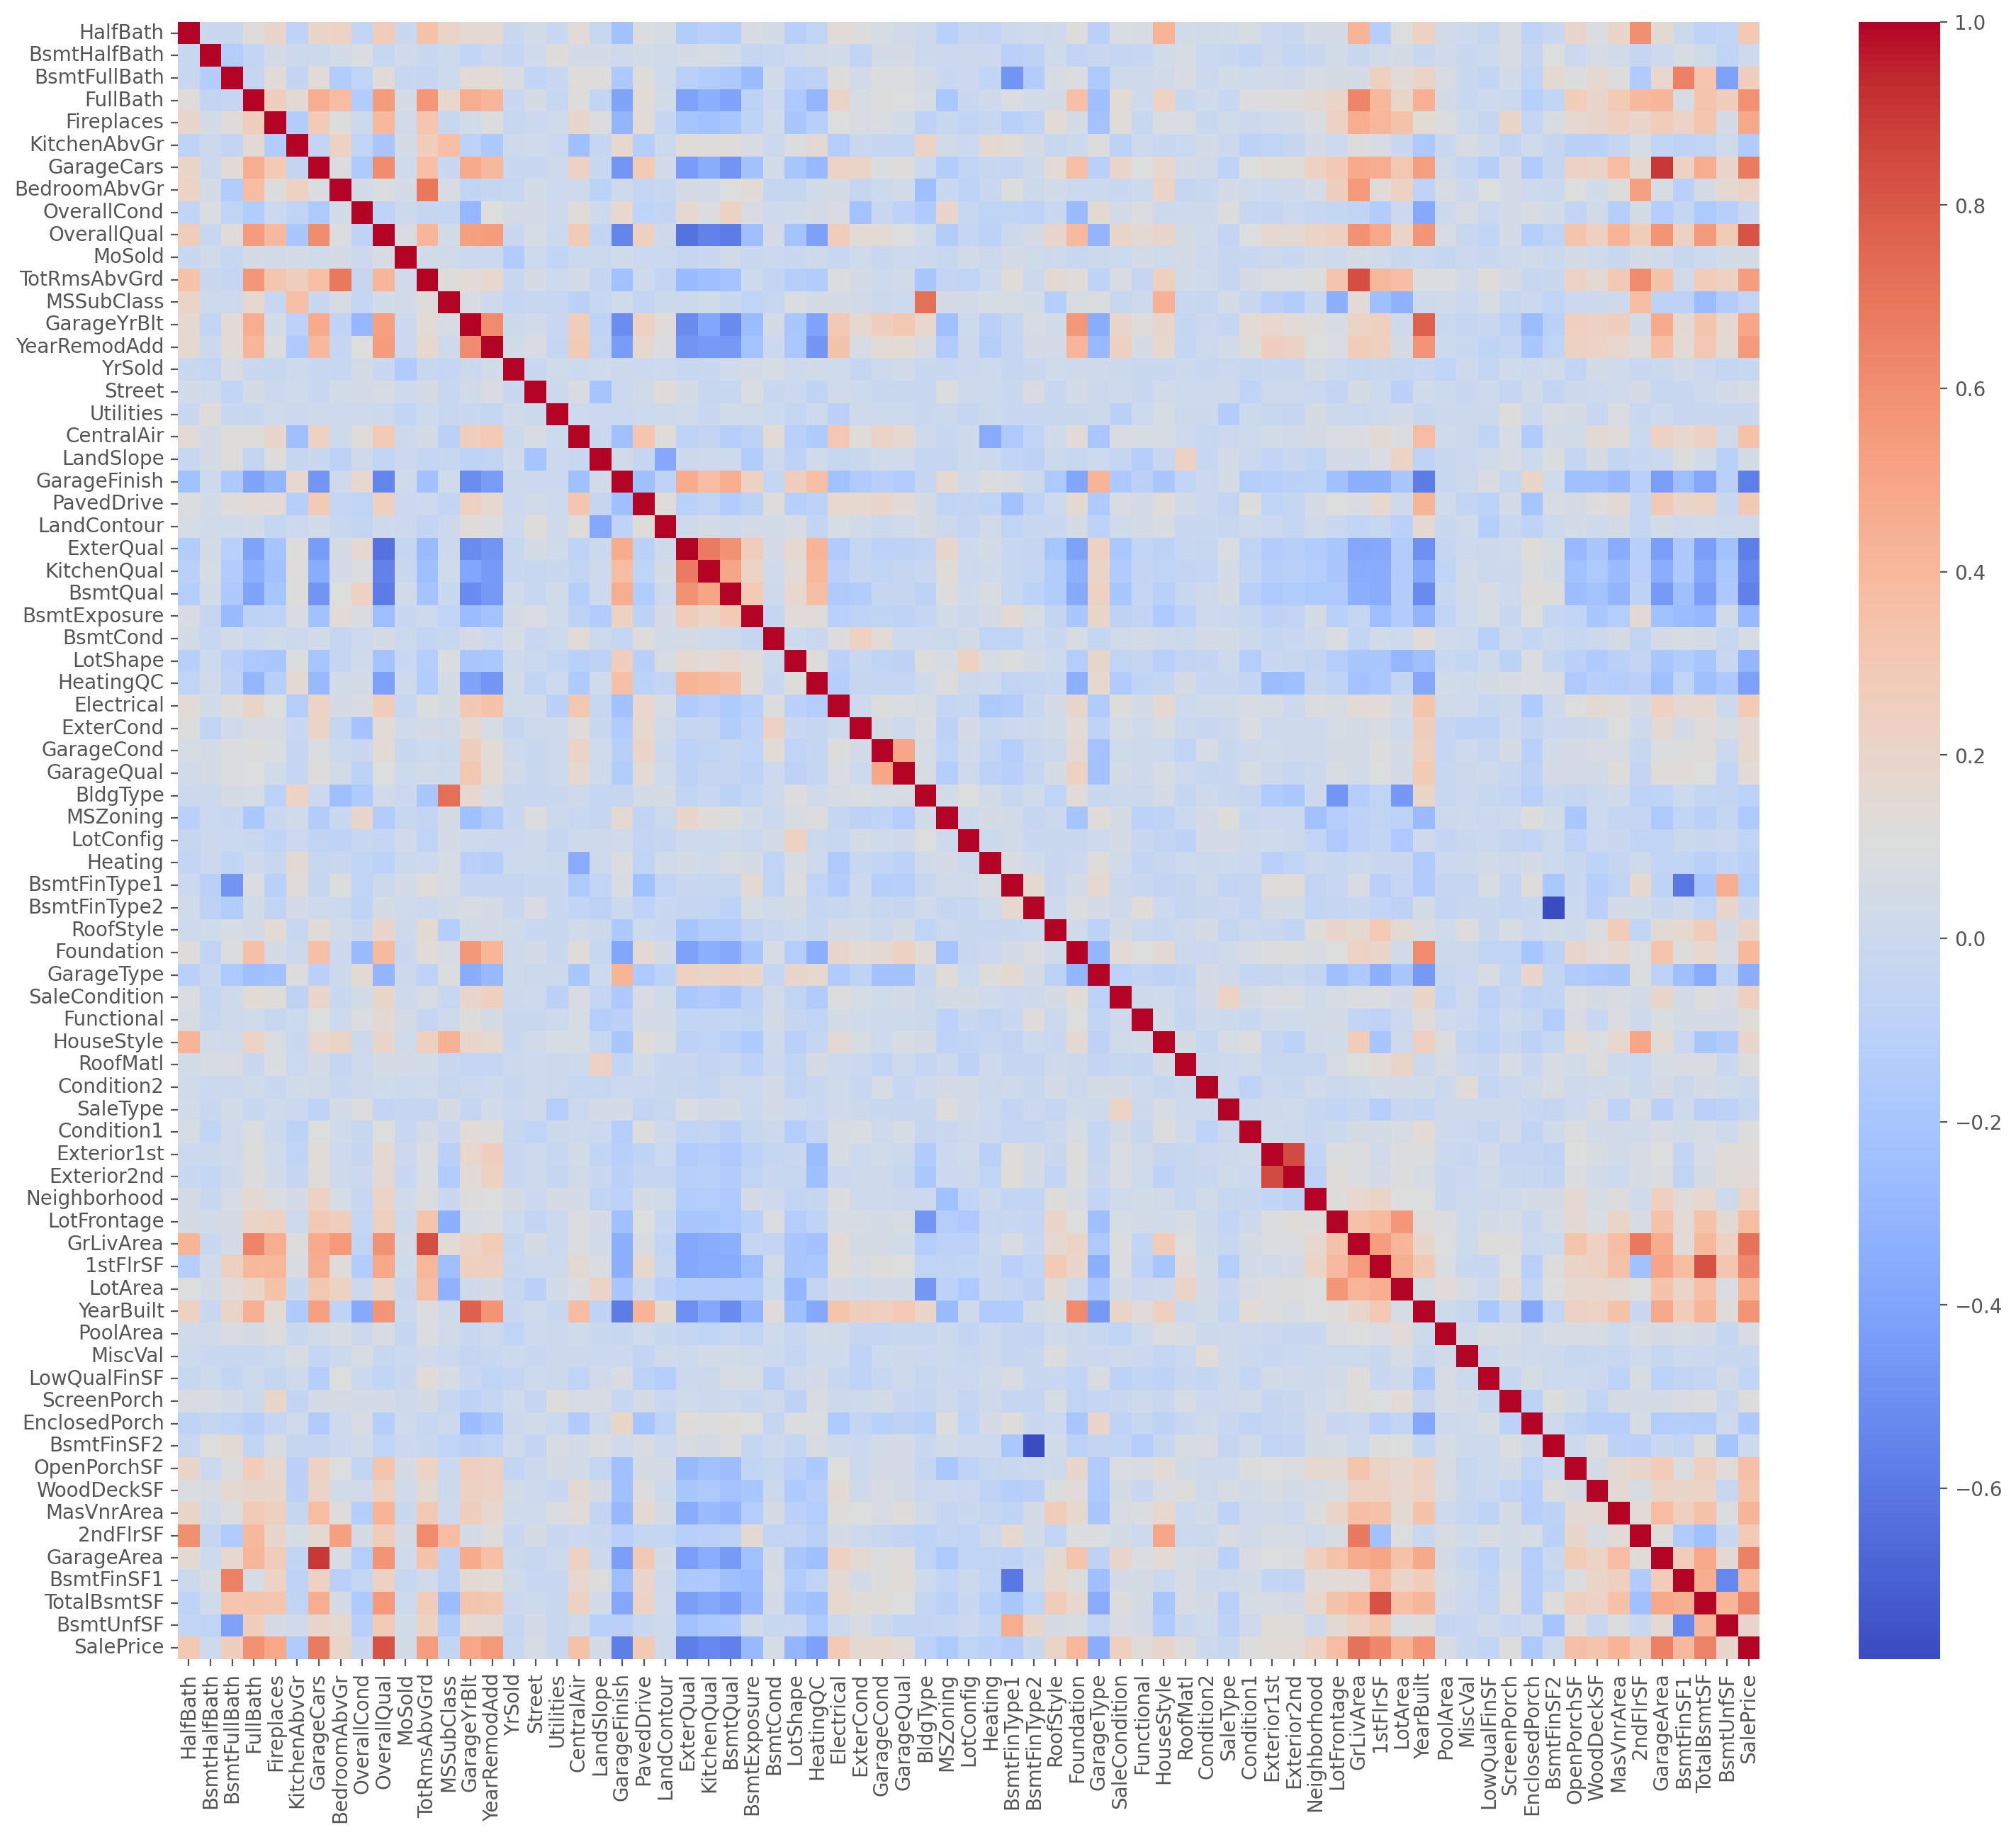

In [29]:
plt.figure(figsize=(18, 15), dpi=200)  # увеличенный размер
sns.heatmap(prec_df.corr(), fmt=".2f", cmap="coolwarm", annot_kws={"size": 8})

#### Прогоняем Optune для DecisionTreeRegressor


In [30]:
def objective(trial):
    # Гиперпараметры модели
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 7)
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]
    )

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-04 11:19:23,894] A new study created in memory with name: no-name-3c5108b7-61ec-4c24-a9ad-11daedb6be92
[I 2025-07-04 11:19:23,979] Trial 0 finished with value: 0.17539594162327865 and parameters: {'max_depth': 8, 'min_samples_leaf': 3, 'criterion': 'poisson'}. Best is trial 0 with value: 0.17539594162327865.
[I 2025-07-04 11:19:24,195] Trial 1 finished with value: 0.1897979564675355 and parameters: {'max_depth': 15, 'min_samples_leaf': 7, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.17539594162327865.
[I 2025-07-04 11:19:24,267] Trial 2 finished with value: 0.18130755693355508 and parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'criterion': 'poisson'}. Best is trial 0 with value: 0.17539594162327865.
[I 2025-07-04 11:19:24,335] Trial 3 finished with value: 0.17362693914099958 and parameters: {'max_depth': 9, 'min_samples_leaf': 3, 'criterion': 'poisson'}. Best is trial 3 with value: 0.17362693914099958.
[I 2025-07-04 11:19:24,407] Trial 4 finished with 

In [31]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'max_depth': 9, 'min_samples_leaf': 3, 'criterion': 'poisson'}
18.961168547105974


#### Прогоняем Optune для KNeighborsRegressor


In [ ]:
def objective(trial):
    # Гиперпараметры модели
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)
    metric = trial.suggest_categorical(
        "metric", ["minkowski", "chebyshev", "manhattan", "euclidean"]
    )

    model = KNeighborsRegressor(
        n_neighbors=n_neighbors, weights=weights, p=p, metric=metric
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

[I 2025-07-04 11:22:47,964] A new study created in memory with name: no-name-b5ff2f73-c28e-4a78-a7ce-76701aa17857
[I 2025-07-04 11:22:48,045] Trial 0 finished with value: 0.20057300843106626 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan'}. Best is trial 0 with value: 0.20057300843106626.
[I 2025-07-04 11:22:48,112] Trial 1 finished with value: 0.19498628063375106 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'p': 1, 'metric': 'manhattan'}. Best is trial 1 with value: 0.19498628063375106.
[I 2025-07-04 11:22:48,180] Trial 2 finished with value: 0.2648450678235855 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'p': 2, 'metric': 'chebyshev'}. Best is trial 1 with value: 0.19498628063375106.
[I 2025-07-04 11:22:48,251] Trial 3 finished with value: 0.19584786478557156 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 1, 'metric': 'minkowski'}. Best is trial 1 with value: 0.19498628063375106.
[I 2025-07-04 11:22:4

In [40]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'n_neighbors': 13, 'weights': 'distance', 'p': 1, 'metric': 'manhattan'}
20.433508704420063


#### Прогоняем Optune для RandomForestRegressor


In [41]:
def objective(trial):
    # Гиперпараметры модели
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 7)
    criterion = trial.suggest_categorical(
        "criterion", ["squared_error", "friedman_mse", "absolute_error", "poisson"]
    )

    model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42,
        n_estimators=100,
    )

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)
    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-04 11:26:17,715] A new study created in memory with name: no-name-0b68ee14-a899-461c-b250-0d9cde4d35ef
[I 2025-07-04 11:26:18,449] Trial 0 finished with value: 0.1350215924357621 and parameters: {'max_depth': 14, 'min_samples_leaf': 6, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.1350215924357621.
[I 2025-07-04 11:26:19,392] Trial 1 finished with value: 0.13259781639246504 and parameters: {'max_depth': 14, 'min_samples_leaf': 3, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.13259781639246504.
[I 2025-07-04 11:26:20,296] Trial 2 finished with value: 0.13183457709230237 and parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'criterion': 'friedman_mse'}. Best is trial 2 with value: 0.13183457709230237.
[I 2025-07-04 11:26:29,841] Trial 3 finished with value: 0.13589004795283388 and parameters: {'max_depth': 13, 'min_samples_leaf': 2, 'criterion': 'absolute_error'}. Best is trial 2 with value: 0.13183457709230237.
[I 2025-07-04 11:26:30,723] Tria

In [42]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'max_depth': 15, 'min_samples_leaf': 2, 'criterion': 'friedman_mse'}
13.973698464076998


#### Прогоняем Optune для CatBoostRegressor


In [43]:
def objective(trial):
    params = {
        "iterations": 1000,
        "early_stopping_rounds": 50,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1, 20),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "verbose": 0,
        "loss_function": "RMSE",
        "random_state": 42,
    }

    model = CatBoostRegressor(**params)

    # Трансформер
    ml_pipeline = Pipeline(
        [
            ("inputering", my_inputer),
            ("cuttering", my_cutter),
            ("scaling", my_scaler_and_encoder),
            ("model", model),
        ]
    )

    trained_model = ml_pipeline.fit(X_train, y_train)
    y_test_proba = trained_model.predict(X_test)

    return root_mean_squared_error(y_test, y_test_proba)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-04 11:28:24,692] A new study created in memory with name: no-name-8cb5d4c4-f6b4-41e2-91f9-6acc8418652f
[I 2025-07-04 11:28:28,244] Trial 0 finished with value: 0.11438972476348358 and parameters: {'depth': 9, 'learning_rate': 0.010908156560323162, 'l2_leaf_reg': 1.1048008298737768, 'bagging_temperature': 0.30393334355729484, 'border_count': 85, 'random_strength': 14.3016881442073, 'grow_policy': 'Lossguide', 'subsample': 0.9875676746401116}. Best is trial 0 with value: 0.11438972476348358.
[I 2025-07-04 11:28:31,036] Trial 1 finished with value: 0.113409693207601 and parameters: {'depth': 6, 'learning_rate': 0.019125986393727104, 'l2_leaf_reg': 1.8247627885472628, 'bagging_temperature': 0.0363112259672993, 'border_count': 196, 'random_strength': 18.55131023596663, 'grow_policy': 'Lossguide', 'subsample': 0.5609974091968377}. Best is trial 1 with value: 0.113409693207601.
[I 2025-07-04 11:28:46,072] Trial 2 finished with value: 0.23822511371522528 and parameters: {'depth': 10

In [44]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'depth': 4, 'learning_rate': 0.02658405170681642, 'l2_leaf_reg': 1.9743324747389903, 'bagging_temperature': 0.49859192926962215, 'border_count': 178, 'random_strength': 1.9352388517796926, 'grow_policy': 'Lossguide', 'subsample': 0.9569067627252543}
11.522983397245428


#### ФИНАЛ ДЛЯ KAGGLE


In [19]:
lr = LinearRegression()
dt = DecisionTreeRegressor(max_depth=9, min_samples_leaf=3, criterion="poisson", random_state=42)
knn = KNeighborsRegressor(n_neighbors=13, p=1, weights="distance", metric="manhattan")
rfr = RandomForestRegressor(max_depth=15, min_samples_leaf=2,criterion='friedman_mse', random_state=42, n_estimators=100)
cb = CatBoostRegressor(
    iterations=1000,
    early_stopping_rounds=50,
    depth=4,
    learning_rate=0.02658405170681642,
    l2_leaf_reg=1.9743324747389903,
    bagging_temperature=0.49859192926962215,
    border_count=178,
    random_strength=1.9352388517796926,
    grow_policy='Lossguide',
    subsample=0.9569067627252543,
    verbose=0,
    loss_function="RMSE",
    random_state=42,
)

In [20]:
def objective(trial):
    # Гиперпараметры модели
    raw_weights = [trial.suggest_float(f'w{i}', 0.001, 1.0) for i in range(5)]
    weight_sum = sum(raw_weights)
    weights_dirichle = [w / weight_sum for w in raw_weights]

    voting = VotingRegressor(
        estimators=[("lr", lr), ("dt", dt), ("knn", knn), ("rfr", rfr), ("cb", cb)],
        weights=weights_dirichle,
    )

    pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('model', voting)
        ]

    )

    trained_model = pipe.fit(X_train, y_train)
    y_pred = trained_model.predict(X_test)

    return root_mean_squared_error(y_test, y_pred)  # RMSE


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-07-04 14:16:07,505] A new study created in memory with name: no-name-a4b41c3f-d704-4702-b7c0-90d6f8e1793e
[I 2025-07-04 14:16:09,922] Trial 0 finished with value: 0.13178869816807678 and parameters: {'w0': 0.4520962102139616, 'w1': 0.9391207368114403, 'w2': 0.9072328073440338, 'w3': 0.5033473206748696, 'w4': 0.16516798227681834}. Best is trial 0 with value: 0.13178869816807678.
[I 2025-07-04 14:16:12,061] Trial 1 finished with value: 0.11737622104810785 and parameters: {'w0': 0.2667350787976818, 'w1': 0.31992998104143555, 'w2': 0.35414587976028034, 'w3': 0.5346478109758622, 'w4': 0.7269018093173597}. Best is trial 1 with value: 0.11737622104810785.
[I 2025-07-04 14:16:14,433] Trial 2 finished with value: 0.13447747511515998 and parameters: {'w0': 0.15057093702534374, 'w1': 0.3572175492324251, 'w2': 0.9276452824678498, 'w3': 0.8180958012058833, 'w4': 0.17074089657817107}. Best is trial 1 with value: 0.11737622104810785.
[I 2025-07-04 14:16:16,974] Trial 3 finished with value: 0.

In [22]:
print(study.best_params)
print(np.expm1(study.best_value) * 100)

{'w0': 0.40174425239901457, 'w1': 0.11749980695786053, 'w2': 0.0015768146750491374, 'w3': 0.18934906928273357, 'w4': 0.7061031129090075}
11.392496385092342


In [26]:
voting = VotingRegressor(
        estimators=[("lr", lr), ("dt", dt), ("knn", knn), ("rfr", rfr), ("cb", cb)],
        weights=[0.40174425239901457, 0.11749980695786053, 0.0015768146750491374, 0.18934906928273357, 0.7061031129090075],
    )

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', voting)
    ]
)

In [27]:
final_model = pipe.fit(X_train, y_train)

In [28]:
y_final = final_model.predict(real_test)
y_final


array([11.70606343, 11.97410426, 12.1279866 , ..., 12.01560923,
       11.70311027, 12.40270058], shape=(1459,))

In [30]:
final_csv = pd.DataFrame(np.exp(y_final), real_test.index).reset_index()
final_csv.columns = ["Id", "SalePrice"]
final_csv.to_csv("submission1.csv", index=False)